In [ ]:
# This information helps with debugging and getting support :)
import sys, platform
import pandas as pd
import bifacial_radiance as br
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("bifacial_radiance version ", br.__version__)

# 9 - Torquetube Shading
## Recreating JPV 2019 / PVSC 2018 Fig. 13


Calculating and plotting shading from torque tube on 1-axis tracking for 1 day, which is figure 13 in: 

            Ayala Pelaez S, Deline C, Greenberg P, Stein JS, Kostuk RK. Model and validation of single-axis tracking with bifacial PV. IEEE J Photovoltaics. 2019;9(3):715–21. https://ieeexplore.ieee.org/document/8644027 and https://www.nrel.gov/docs/fy19osti/72039.pdf (pre-print, conference version)


This is what we will re-create:
![Ayala JPV-2](../images_wiki/JPV_Ayala_Fig13.PNG)

Use bifacial_radiance minimum v. 0.3.1 or higher. Many things have been updated since this paper, simplifying the generation of this plot:

* Sensor position is now always generated E to W on N-S tracking systems, so same sensor positions can just be added for this calculation at the end without needing to flip the sensors.
* Torquetubes get automatically generated in makeModule. Following PVSC 2018 paper, rotation is around the modules and not around the torque tube axis (which is a new feature)
* Simulating only 1 day on single-axis tracking easier with cumulativesky = False and gendaylit1axis(startdate='06/24', enddate='06/24'
* Sensors get generated very close to surface, so all results are from the module surface and not the torquetube for this 1-UP case. 

## Steps:

1. <a href='#step1'> Running the simulations for all the cases:
  1. <a href='#step1a'>Baseline Case: No Torque Tube </a>
  2. <a href='#step1b'> Zgap = 0.1 </a>
  3. <a href='#step1c'> Zgap = 0.2 </a>
  4. <a href='#step1d'> Zgap = 0.3 </a>
2. <a href='#step2'> Read-back the values and tabulate average values for unshaded, 10cm gap and 30cm gap </a>
3. <a href='#step3'> Plot spatial loss values for 10cm and 30cm data </a>
4. <a href='#step4'> Overall Shading Factor (for 1 day) </a>



<a id='step1'></a>

### 1. Running the simulations for all the cases

In [1]:
import os
from pathlib import Path

testfolder = str(Path().resolve().parent.parent / 'bifacial_radiance' / 'TEMP' / 'Tutorial_09')
if not os.path.exists(testfolder):
    os.makedirs(testfolder)

print ("Your simulation will be stored in %s" % testfolder)

Your simulation will be stored in C:\Users\mprillim\sam_dev\bifacial_radiance\bifacial_radiance\TEMP\Tutorial_09


In [2]:
# VARIABLES of the simulation: 
lat = 35.1 # ABQ
lon = -106.7 # ABQ
x=1
y = 2 
numpanels=1
limit_angle = 45 # tracker rotation limit angle
backtrack = True
albedo = 'concrete'     # ground albedo
hub_height = y*0.75   # H = 0.75 
gcr = 0.35  
pitch = y/gcr
#pitch = 1.0/gcr # Check from 1Axis_Shading_PVSC2018 file
cumulativesky = False # needed for set1axis and makeScene1axis so simulation is done hourly not with gencumsky.
limit_angle = 45 # tracker rotation limit angle
nMods=10
nRows=3
sensorsy = 200
module_type='test-module'
datewanted='06_24' # sunny day 6/24/1972 (index 4180 - 4195). Valid formats starting version 0.4.0 for full day sim: mm_dd

## Torque tube info
tubetype='round'
material = 'Metal_Grey'
diameter = 0.1
axisofrotationTorqueTube = False   # Original PVSC version rotated around the modules like most other software.
# Variables that will get defined on each iteration below:
zgap = 0 # 0.2, 0.3 values tested. Re-defined on each simulation.
visible = False # baseline is no torque tube.


In [3]:
# Simulation Start.
import bifacial_radiance
import numpy as np

print(bifacial_radiance.__version__)

demo = bifacial_radiance.RadianceObj(path = testfolder)  
demo.setGround(albedo)
epwfile = demo.getEPW(lat, lon) 
metdata = demo.readWeatherFile(epwfile, starttime=datewanted, endtime=datewanted) 
trackerdict = demo.set1axis(metdata, limit_angle = limit_angle, backtrack = backtrack, gcr = gcr, cumulativesky = cumulativesky)
trackerdict = demo.gendaylit1axis() 
sceneDict = {'pitch':pitch,'hub_height':hub_height, 'nMods': nMods, 'nRows': nRows}  

0+untagged.1552.g4b73b19.dirty
path = C:\Users\mprillim\sam_dev\bifacial_radiance\bifacial_radiance\TEMP\Tutorial_09
Making path: images
Making path: objects
Making path: results
Making path: skies
Making path: EPWs
Making path: materials
Loading albedo, 1 value(s), 0.281 avg
1 nonzero albedo values.
Getting weather file: USA_NM_Albuquerque.723650_TMY2.epw
 ... OK!
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Filtering dates
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Creating ~14 skyfiles. 
Created 13 skyfiles in /skies/


<a id='step1a'></a>

### A. Baseline Case: No Torque Tube

When torquetube is False, zgap is the distance from axis of torque tube to module surface, but since we are rotating from the module's axis, this Zgap doesn't matter for this baseline case.

In [4]:
#CASE 0 No torque tube
# When torquetube is False, zgap is the distance from axis of torque tube to module surface, but since we are rotating from the module's axis, this Zgap doesn't matter.
# zgap = 0.1 + diameter/2.0  
torquetube = False 
customname = '_NoTT'
module_NoTT = demo.makeModule(name=customname,x=x,y=y, numpanels=numpanels)
module_NoTT.addTorquetube(visible=False, axisofrotation=False, diameter=0)
trackerdict = demo.makeScene1axis(trackerdict, module_NoTT, sceneDict, cumulativesky = cumulativesky) 
trackerdict = demo.makeOct1axis(trackerdict)
trackerdict = demo.analysis1axis(trackerdict, sensorsy = sensorsy, customname = customname)



Module Name: _NoTT
Module _NoTT updated in module.json
Module _NoTT updated in module.json
Pre-existing .rad file objects\_NoTT.rad will be overwritten


Making ~13 .rad files for gendaylit 1-axis workflow (this takes a minute..)
13 Radfiles created in /objects/

Making 13 octfiles in root directory.
Created 1axis_2021-06-24_0600.oct
Created 1axis_2021-06-24_0700.oct
Created 1axis_2021-06-24_0800.oct
Created 1axis_2021-06-24_0900.oct
Created 1axis_2021-06-24_1000.oct
Created 1axis_2021-06-24_1100.oct
Created 1axis_2021-06-24_1200.oct
Created 1axis_2021-06-24_1300.oct
Created 1axis_2021-06-24_1400.oct
Created 1axis_2021-06-24_1500.oct
Created 1axis_2021-06-24_1600.oct
Created 1axis_2021-06-24_1700.oct
Created 1axis_2021-06-24_1800.oct
Linescan in process: 1axis_2021-06-24_0600_NoTT_Front
Linescan in process: 1axis_2021-06-24_0600_NoTT_Back
Saved: results\irr_1axis_2021-06-24_0600_NoTT.csv
Index: 2021-06-24_0600. Wm2Front: 160.88263616666666. Wm2Back: 17.052301766666666
Linescan in proc

<a id='step1b'></a>

### B. ZGAP = 0.1

In [5]:
#ZGAP 0.1 
zgap = 0.1
customname = '_zgap0.1'
tubeParams = {'tubetype':tubetype,
              'diameter':diameter,
              'material':material,
              'axisofrotation':False,
              'visible':True} # either pass this into makeModule, or separately into module.addTorquetube()
module_zgap01 = demo.makeModule(name=customname, x=x,y=y, numpanels=numpanels, zgap=zgap, tubeParams=tubeParams)
trackerdict = demo.makeScene1axis(trackerdict, module_zgap01, sceneDict, cumulativesky = cumulativesky) 
trackerdict = demo.makeOct1axis(trackerdict)
trackerdict = demo.analysis1axis(trackerdict, sensorsy = sensorsy, customname = customname)


Module Name: _zgap0.1
Module _zgap0.1 updated in module.json

Making ~13 .rad files for gendaylit 1-axis workflow (this takes a minute..)
13 Radfiles created in /objects/

Making 13 octfiles in root directory.
Created 1axis_2021-06-24_0600.oct
Created 1axis_2021-06-24_0700.oct
Created 1axis_2021-06-24_0800.oct
Created 1axis_2021-06-24_0900.oct
Created 1axis_2021-06-24_1000.oct
Created 1axis_2021-06-24_1100.oct
Created 1axis_2021-06-24_1200.oct
Created 1axis_2021-06-24_1300.oct
Created 1axis_2021-06-24_1400.oct
Created 1axis_2021-06-24_1500.oct
Created 1axis_2021-06-24_1600.oct
Created 1axis_2021-06-24_1700.oct
Created 1axis_2021-06-24_1800.oct
Linescan in process: 1axis_2021-06-24_0600_zgap0.1_Front
Linescan in process: 1axis_2021-06-24_0600_zgap0.1_Back
Saved: results\irr_1axis_2021-06-24_0600_zgap0.1.csv
Index: 2021-06-24_0600. Wm2Front: 160.898549. Wm2Back: 16.260428746666665
Linescan in process: 1axis_2021-06-24_0700_zgap0.1_Front
Linescan in process: 1axis_2021-06-24_0700_zgap0.1

<a id='step1c'></a>

### C. ZGAP = 0.2

In [6]:
#ZGAP 0.2
zgap = 0.2
customname = '_zgap0.2'
tubeParams = {'tubetype':tubetype,
              'diameter':diameter,
              'material':material,
              'axisofrotation':False,
              'visible':True} # either pass this into makeModule, or separately into module.addTorquetube()
module_zgap02 = demo.makeModule(name=customname, x=x,y=y, numpanels=numpanels,zgap=zgap, tubeParams=tubeParams)
trackerdict = demo.makeScene1axis(trackerdict, module_zgap02, sceneDict, cumulativesky = cumulativesky) 
trackerdict = demo.makeOct1axis(trackerdict)
trackerdict = demo.analysis1axis(trackerdict, sensorsy = sensorsy, customname = customname)


Module Name: _zgap0.2
Module _zgap0.2 updated in module.json

Making ~13 .rad files for gendaylit 1-axis workflow (this takes a minute..)
13 Radfiles created in /objects/

Making 13 octfiles in root directory.
Created 1axis_2021-06-24_0600.oct
Created 1axis_2021-06-24_0700.oct
Created 1axis_2021-06-24_0800.oct
Created 1axis_2021-06-24_0900.oct
Created 1axis_2021-06-24_1000.oct
Created 1axis_2021-06-24_1100.oct
Created 1axis_2021-06-24_1200.oct
Created 1axis_2021-06-24_1300.oct
Created 1axis_2021-06-24_1400.oct
Created 1axis_2021-06-24_1500.oct
Created 1axis_2021-06-24_1600.oct
Created 1axis_2021-06-24_1700.oct
Created 1axis_2021-06-24_1800.oct
Linescan in process: 1axis_2021-06-24_0600_zgap0.2_Front
Linescan in process: 1axis_2021-06-24_0600_zgap0.2_Back
Saved: results\irr_1axis_2021-06-24_0600_zgap0.2.csv
Index: 2021-06-24_0600. Wm2Front: 160.95127333333335. Wm2Back: 16.368343216666666
Linescan in process: 1axis_2021-06-24_0700_zgap0.2_Front
Linescan in process: 1axis_2021-06-24_0700

<a id='step1d'></a>

### D. ZGAP = 0.3

In [7]:
#ZGAP 0.3
zgap = 0.3
customname = '_zgap0.3'
tubeParams = {'tubetype':tubetype,
              'diameter':diameter,
              'material':material,
              'axisofrotation':False,
              'visible':True} # either pass this into makeModule, or separately into module.addTorquetube()
module_zgap03 = demo.makeModule(name=customname,x=x,y=y, numpanels=numpanels, zgap=zgap, tubeParams=tubeParams)
trackerdict = demo.makeScene1axis(trackerdict, module_zgap03, sceneDict, cumulativesky = cumulativesky) 
trackerdict = demo.makeOct1axis(trackerdict)
trackerdict = demo.analysis1axis(trackerdict, sensorsy = sensorsy, customname = customname)


Module Name: _zgap0.3
Module _zgap0.3 updated in module.json

Making ~13 .rad files for gendaylit 1-axis workflow (this takes a minute..)
13 Radfiles created in /objects/

Making 13 octfiles in root directory.
Created 1axis_2021-06-24_0600.oct
Created 1axis_2021-06-24_0700.oct
Created 1axis_2021-06-24_0800.oct
Created 1axis_2021-06-24_0900.oct
Created 1axis_2021-06-24_1000.oct
Created 1axis_2021-06-24_1100.oct
Created 1axis_2021-06-24_1200.oct
Created 1axis_2021-06-24_1300.oct
Created 1axis_2021-06-24_1400.oct
Created 1axis_2021-06-24_1500.oct
Created 1axis_2021-06-24_1600.oct
Created 1axis_2021-06-24_1700.oct
Created 1axis_2021-06-24_1800.oct
Linescan in process: 1axis_2021-06-24_0600_zgap0.3_Front
Linescan in process: 1axis_2021-06-24_0600_zgap0.3_Back
Saved: results\irr_1axis_2021-06-24_0600_zgap0.3.csv
Index: 2021-06-24_0600. Wm2Front: 160.92600333333334. Wm2Back: 16.4185512
Linescan in process: 1axis_2021-06-24_0700_zgap0.3_Front
Linescan in process: 1axis_2021-06-24_0700_zgap0.3

<a id='step2'></a>

### 2. Read-back the values and tabulate average values for unshaded, 10cm gap and 30cm gap


In [8]:
import glob
import pandas as pd

resultsfolder = os.path.join(testfolder, 'results')
print (resultsfolder)
filenames = glob.glob(os.path.join(resultsfolder,'*.csv'))
noTTlist = [k for k in filenames if 'NoTT' in k]
zgap10cmlist = [k for k in filenames if 'zgap0.1' in k]
zgap20cmlist = [k for k in filenames if 'zgap0.2' in k]
zgap30cmlist = [k for k in filenames if 'zgap0.3' in k]

# sum across all hours for each case
unsh_front = np.array([pd.read_csv(f, engine='python')['Wm2Front'] for f in noTTlist]).sum(axis = 0)
cm10_front = np.array([pd.read_csv(f, engine='python')['Wm2Front'] for f in zgap10cmlist]).sum(axis = 0)
cm20_front = np.array([pd.read_csv(f, engine='python')['Wm2Front'] for f in zgap20cmlist]).sum(axis = 0)
cm30_front = np.array([pd.read_csv(f, engine='python')['Wm2Front'] for f in zgap30cmlist]).sum(axis = 0)
unsh_back = np.array([pd.read_csv(f, engine='python')['Wm2Back'] for f in noTTlist]).sum(axis = 0)
cm10_back = np.array([pd.read_csv(f, engine='python')['Wm2Back'] for f in zgap10cmlist]).sum(axis = 0)
cm20_back = np.array([pd.read_csv(f, engine='python')['Wm2Back'] for f in zgap20cmlist]).sum(axis = 0)
cm30_back = np.array([pd.read_csv(f, engine='python')['Wm2Back'] for f in zgap30cmlist]).sum(axis = 0)

C:\Users\mprillim\sam_dev\bifacial_radiance\bifacial_radiance\TEMP\Tutorial_09\results


<a id='step3'></a>

### 3. plot spatial loss values for 10cm and 30cm data

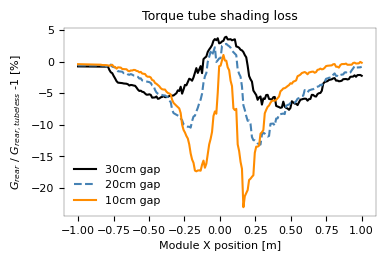

In [14]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['axes.linewidth'] = 0.2 #set the value globally

fig = plt.figure()
fig.set_size_inches(4, 2.5)
ax = fig.add_axes((0.15,0.15,0.78,0.75))
#plt.rc('font', family='sans-serif')
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.rc('axes',labelsize=8)
plt.plot(np.linspace(-1,1,unsh_back.__len__()),(cm30_back - unsh_back)/unsh_back*100, label = '30cm gap',color = 'black')  #steelblue
plt.plot(np.linspace(-1,1,unsh_back.__len__()),(cm20_back - unsh_back)/unsh_back*100, label = '20cm gap',color = 'steelblue', linestyle = '--')  #steelblue
plt.plot(np.linspace(-1,1,unsh_back.__len__()),(cm10_back - unsh_back)/unsh_back*100, label = '10cm gap',color = 'darkorange')  #steelblue
#plt.ylabel('$G_{rear}$ vs unshaded [Wm-2]')#(r'$BG_E$ [%]')
plt.ylabel('$G_{rear}$ / $G_{rear,tubeless}$ -1 [%]')
plt.xlabel('Module X position [m]')
plt.legend(fontsize = 8,frameon = False,loc='best')
#plt.ylim([0, 15])
plt.title('Torque tube shading loss',fontsize=9)
#plt.annotate('South',xy=(-10,9.5),fontsize = 8); plt.annotate('North',xy=(8,9.5),fontsize = 8)
plt.show()

<a id='step4'></a>

### 4. Overall Shading Loss Factor

To calculate shading loss factor, we can use the following equation:



<img src="../images_wiki/AdvancedJournals/Equation_ShadingFactor.PNG">

In [10]:
ShadingFactor = (1 - cm30_back.sum() / unsh_back.sum())*100